In [1]:
!pip install pycocotools     
!pip install opencv-python

In [2]:
import warnings       
warnings.filterwarnings('ignore')

In [3]:
from pycocotools.coco import COCO     
from pathlib import Path

import matplotlib.pyplot as plt
import skimage.io as io
import torchshow as ts
import pandas as pd 
import numpy as np
import math
import os
import copy
import cv2
from PIL import Image
from IPython.display import display
from matplotlib.pyplot import figure

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
# Технические функции для отрисовки картинок

# Функция для отрисовки 12 картинок
def plot_12_images(images, title=None, figsize=(15, 15), rows=3, cols=4):
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.05)
    axs = axs.ravel()
    
    for i, image in enumerate(images):
        axs[i].imshow(image, cmap='gray')
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].set_aspect('equal')
        axs[i].axis('off')
        axs[i].set_title(str(i+1), fontsize=12, pad=3)
    
    for i in range(len(images), rows*cols):
        fig.delaxes(axs[i])
        
    if title:
        plt.suptitle(title, fontsize=16, y=0.95)
    
    plt.show()


    
# То же самое для трех
def plot_three_images(img1, img2, img3, l1, l2, l3):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img1)
    
    ax[0].set_title(l1)
    ax[1].imshow(img2)
    ax[1].set_xlabel(l2, labelpad=10)

    ax[2].imshow(img3,cmap='gray')
    ax[2].set_title(l3)
    plt.show()
# "Изображение после binary tresholding" "Изображение после canny c контурами" "Итоговый результат"

Изображения были размечены в приложении Label studio, так как он как оказалось довольно прост в использовании
и позволляет быстро экспортировать изображения.
Ниже я загружаю эти изображения и маски из формата COCO:


**Вставьте ниже ссылку на папку drywall
и на файл result.json в ней для того чтобы запускать код**


In [5]:
dataDir = '/Users/vadimartemov/Desktop/drywall'  
dataType = 'images'
annFile = '/Users/vadimartemov/Desktop/drywall/result.json'

# initialize COCO api for instance annotations
coco = COCO(annFile)

# get all image IDs
imgIds = coco.getImgIds()

# create empty lists to hold masks and images
mask_list = []
img_list = []

# loop over all images
for imgId in imgIds:
    # load image data
    img_info = coco.loadImgs(imgId)[0]
    img_path = os.path.join(dataDir, dataType, img_info['file_name'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # load annotations for the image
    annIds = coco.getAnnIds(imgIds=imgId, iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    # create empty binary mask for the image
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    
    # loop over all annotations for the image and combine them into a single binary mask
    for ann in anns:
        mask += coco.annToMask(ann)
    
    # append mask and image to their respective lists
    mask_list.append(mask)
    img_list.append(img)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


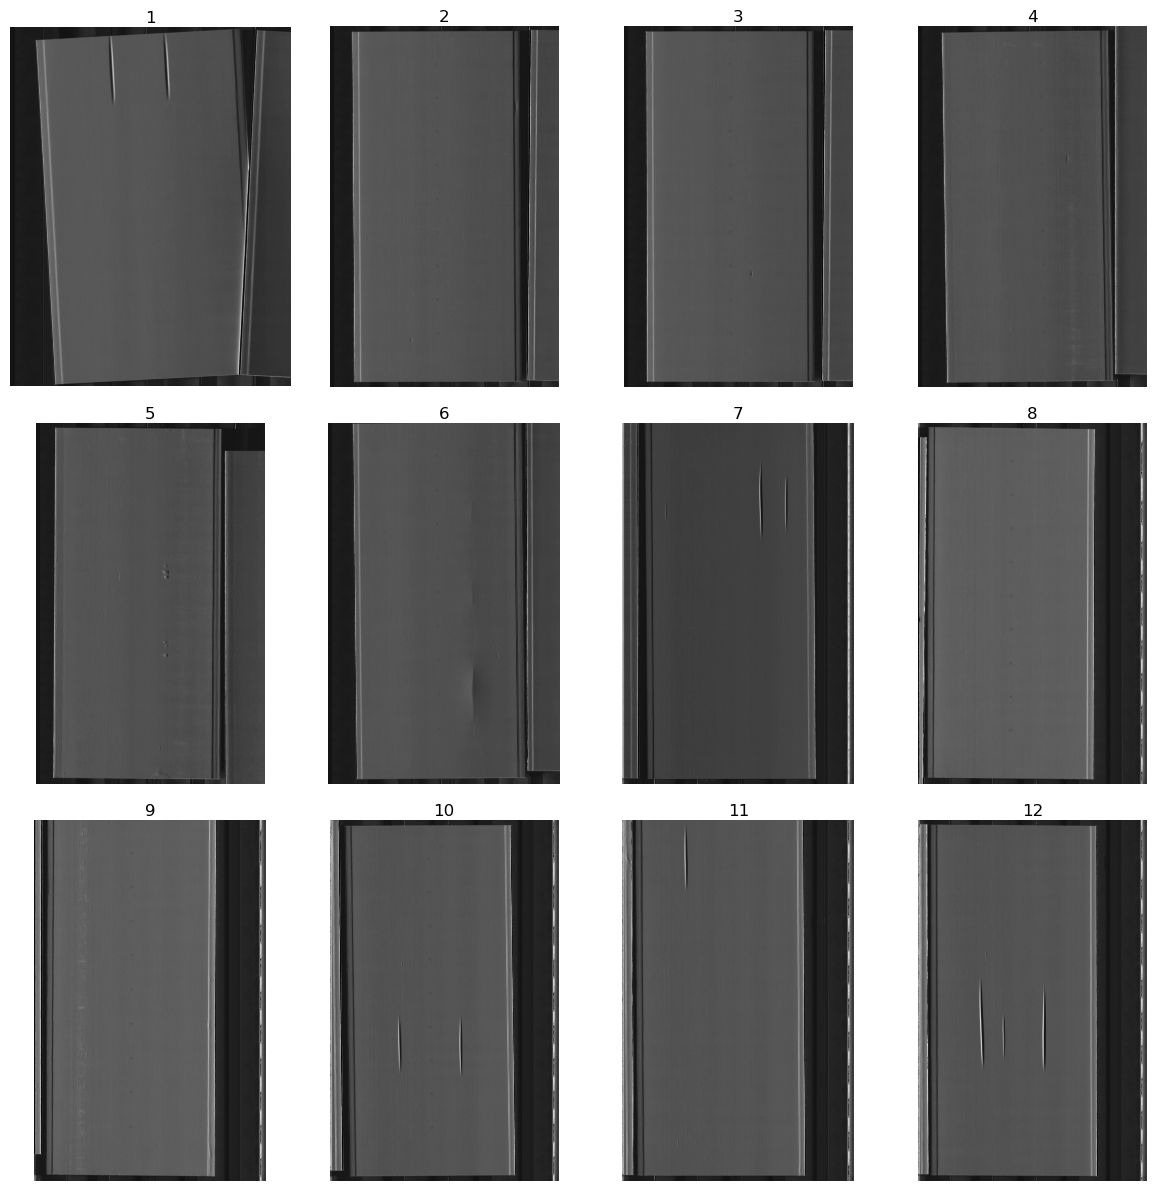

In [6]:
# Выведем картинки, убедимся что все хорошо
plot_12_images(img_list)

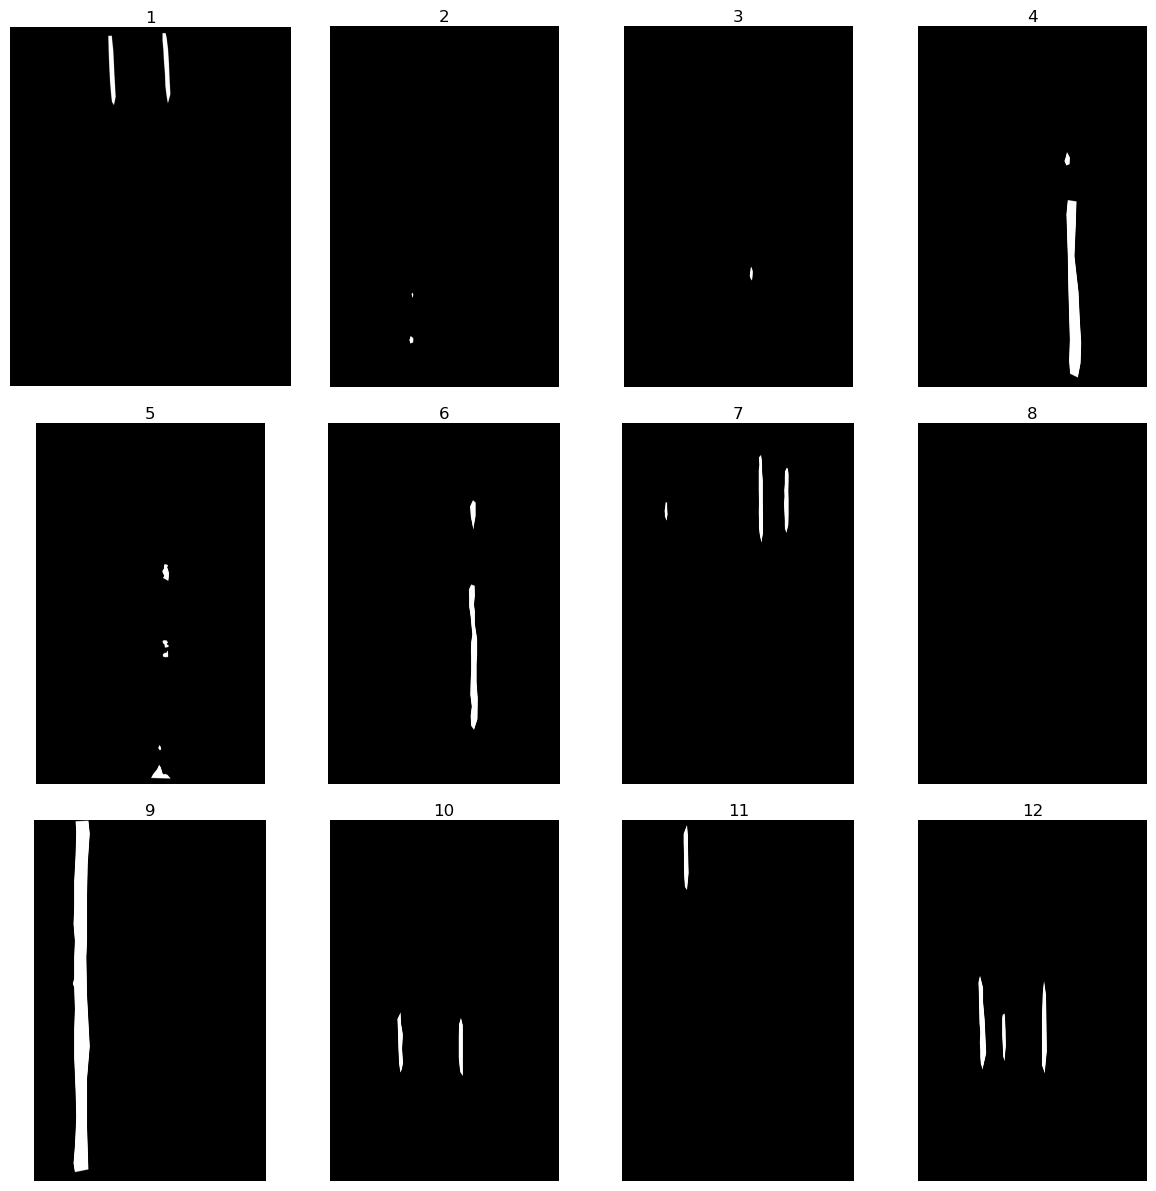

In [7]:
# Выведем маски: такие толстые полоски на картинке 4 и 9 это потертости краски 
plot_12_images(mask_list)

In [8]:
# Выделим область интереса, т.е. отделим сам гипсокартон от фона 

def get_area_of_interest(img):
    
    # Применяем adaptive histogram equalization чтобы лучше отделить гипсокартон от фона, тк гипсокартон светлее
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
    img_eq = clahe.apply(img)
    
    # Теперь применяем Otsu thresholding, который разделит гипсокартон и фон, и при этом выберет лучшие параметры сам
    #_, thresh = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh = cv2.threshold(img_eq, 0, 255, cv2.THRESH_OTSU)

    # Применяем erosion и dilation чтобы убрать артефакты и шумы, 
    # размер ядра и число итераций выбиралось на глаз, до тех пор пока результат не выглядел приемлимым
    kernel = np.ones((6, 6), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations = 3) 
    thresh = cv2.dilate(thresh, kernel, iterations = 3) 

    # Находим собственно контуры в изображении, чтобы найти наибольший (нашу основную пластину гипсокартона)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Отсортируем и возбмем наибольший, опыт показал что в целом этого достаточно
    # Возможно если бы картинки были бы хуже, контуры бы выбирали все изображение, 
    # или были бы неприятные пересечения, тогда пришлось бы смотреть еще на какие-то параметры, но тут повезло
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contour = contours[0]

    # Найдем bounding box для нашего контура
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    # Отсортируем контур чтобы сначала был левый верхний угол, потом правый верхний и т.д.
    # Это нужно чтобы потом случайно контур не развернулся из-за неверного порядка координат
    ordered_box = np.zeros_like(box)
    sums = box.sum(axis=1)
    diffs = np.diff(box, axis=1)
    ordered_box[0] = box[np.argmin(sums)] # Наименьная сумма координат будет у левого верхнего 
    ordered_box[1] = box[np.argmin(diffs)]
    ordered_box[2] = box[np.argmax(sums)]
    ordered_box[3] = box[np.argmax(diffs)]
    
    # Теперь уже формируем упорядоченный контур
    box = np.array(ordered_box, dtype="float32")
    tl, tr, br, bl = box

    # Найдем ширину и высоту конутра
    width = max([np.sqrt(((br[0]-bl[0])**2) + ((br[1]-bl[1])**2)), np.sqrt(((tr[0]-tl[0])**2) + ((tr[1]-tl[1])**2))])
    height = max([np.sqrt(((tr[0]-br[0])**2) + ((tr[1]-br[1])**2)), np.sqrt(((tl[0]-bl[0])**2) + ((tl[1]-bl[1])**2))])

    # Сформируем точки на изображении которые являются координатами area of interest
    dst = np.array([[0, 0],[width-1, 0],[width-1, height-1],[0, height-1]], dtype="float32")

    # Получи преобразование для получения area of interest
    M = cv2.getPerspectiveTransform(box, dst)
    
    # Применяем преобразование
    warped = cv2.warpPerspective(img, M, (int(width), int(height)))

    # Уменьшаем картинку в три раза чтобы упростить дальнейшие вычисления и выдаем результат
    sm_warped = cv2.resize(warped, (0,0), fx=1/3, fy=1/3)
    
    return sm_warped, M

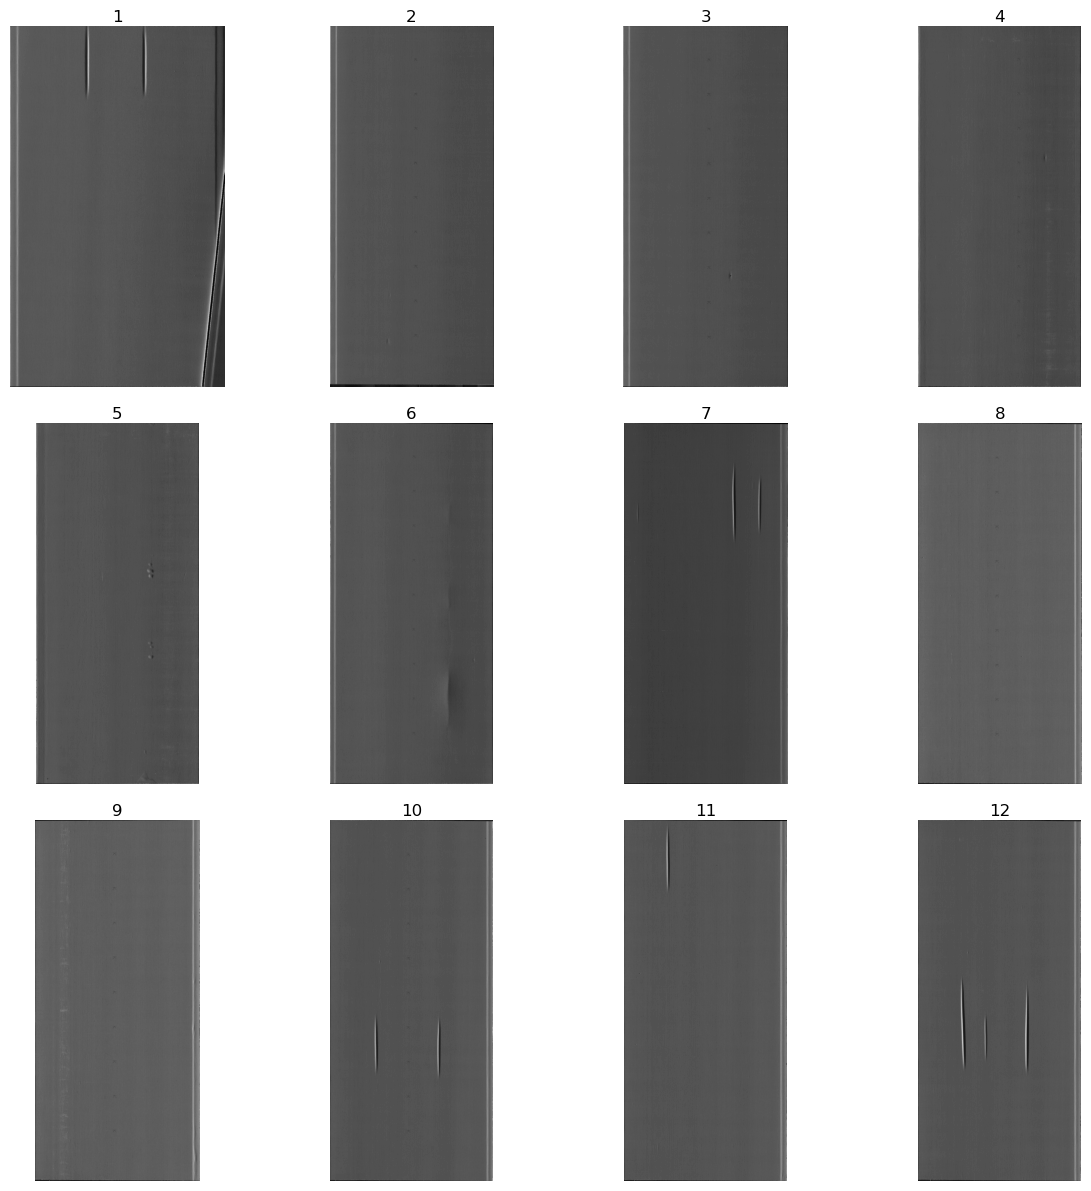

In [9]:
# Загрузим в список все наши контуры и нарисуем результат 
img_dc = [get_area_of_interest(copy.deepcopy(i))[0] for i in img_list]
transforms = [get_area_of_interest(copy.deepcopy(i))[1] for i in img_list] #coxраним информация о трансофрациях чтобы потом восстановить маски 
plot_12_images(img_dc)

В целом получилось приемлимо, зачастую не отделяется боковая изогнутость, но попытка это исправить, 
ломала алгоритм. Это будет учтено позже при выделении дефекторв

На изображении есть несколько видов дефектов, большие царапины (1, 7, 10, 11, 12), 
изгибы (6), сколы (2, 3, 4, 5), потеротости окрашивания (4, 5, 9).
Напишем функции для отделения этих дефектов

In [10]:
# Напишем алгоритм для нахождения длиных царапин, они четко видны и их проще всего распознать 

def detect_long_scratches(img, produce_masks = False):
    
    process = [] #Список для хранения промежуточных результатов
    
    image = copy.deepcopy(img) #сделаем глубокую копию, чтобы не засорять изначальный список
    blur = cv2.GaussianBlur(image, (3,3), 0) #размоем чтобы убрать мелкие шумы

    # Применим Otsu thresholding чтобы лучше отделить царапины от поверхности
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)
    process.append(copy.deepcopy(thresh))
    
    # Создадим квадратное ядро и сделаем opening и затем dilation чтобы избавиться от шумов и лучше выделить царапины
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    openind = cv2.dilate(opening, kernel, iterations = 3) 

    # Найдем границы на изображении методом Canny
    edges = cv2.Canny(opening, 100, 200)
    process.append(copy.deepcopy(edges))

    # Из границ получим контуры
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Отсортируем контуры
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Чтобы боковая каемка или налегающий кусок гипсокартона (как на 0 изображении)
    # не распознавался как трещина, отметем все царапины длинее чем 1/2 ширины или высоты изображения
    contours_scratch = []
    for contour in contours[:10]:
        x, y, w, h = cv2.boundingRect(contour) # получим данные о bounding box котура, нулевая точка и ширина и высота откладываемые от нее
        if h > 0.5*image.shape[0] or w > 0.5*image.shape[1]:
            continue
        else:
            contours_scratch.append(contour)

    # Нарисуем контуры 
    for cnt in contours_scratch:
        cv2.fillPoly(image, [cnt], (255, 255, 255))
        
    # Чтобы получить бинарные маски, будем рисовать контуры не на картинке, а на заготовке 
    if produce_masks:
        mask = np.zeros_like(image)
        for contour in contours_scratch:
            cv2.fillPoly(mask, [contour], 255)
        ret, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
        return binary_mask
        
    # В противном случае вернем картинку с распознанной трещиной и промежуточными изображениями для демонстрации/отладки
    return image, process

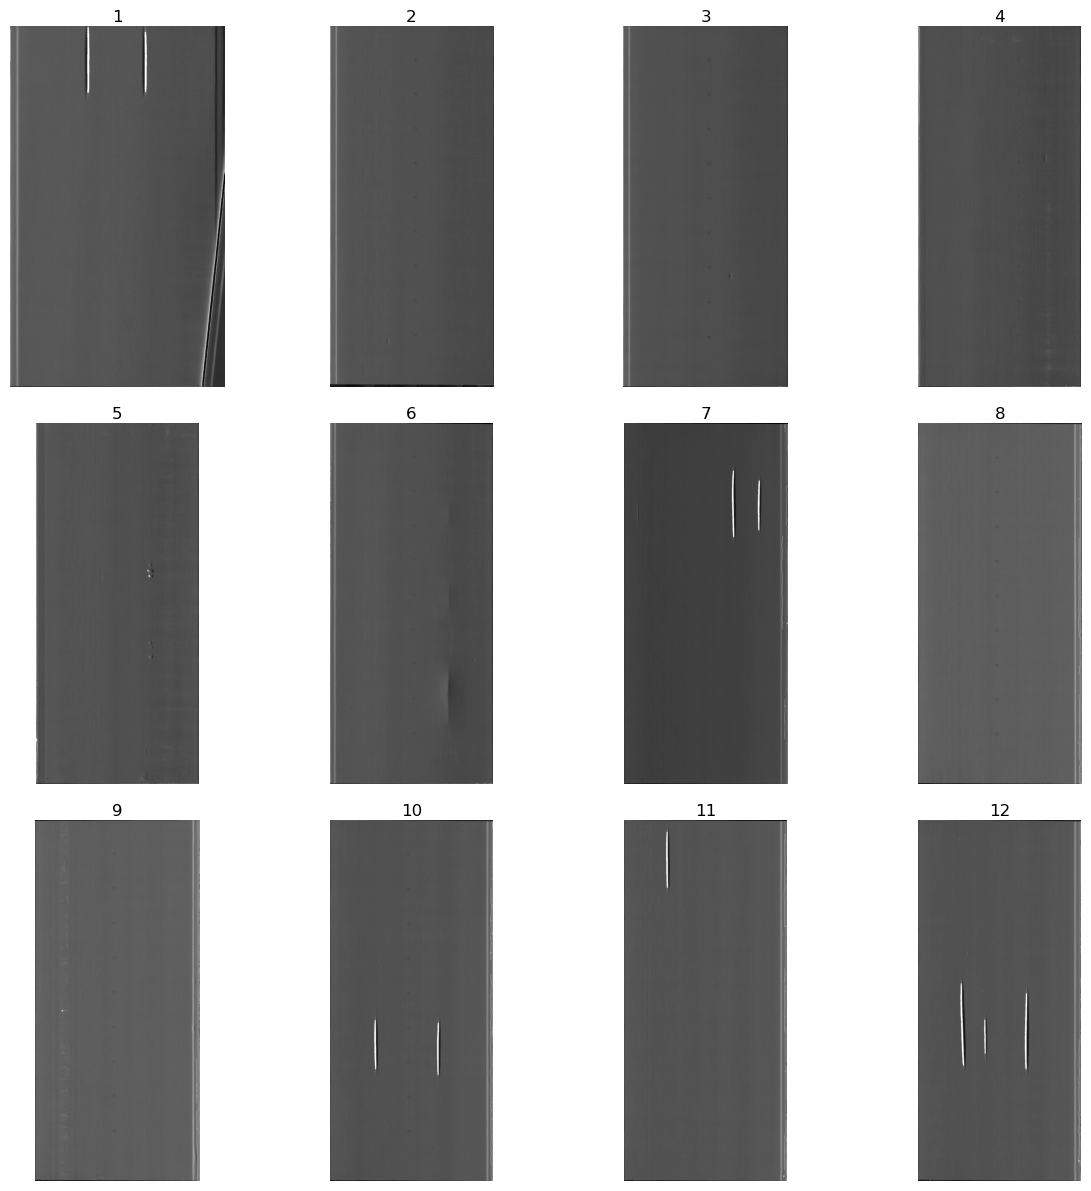

In [11]:
all_outputs = [detect_long_scratches(i) for i in img_dc]
the_resulting_detection = [i[0] for i in all_outputs]
process_images = [i[1] for i in all_outputs]
plot_12_images(the_resulting_detection)

Мы видим что все крупные царапины успешно распознались

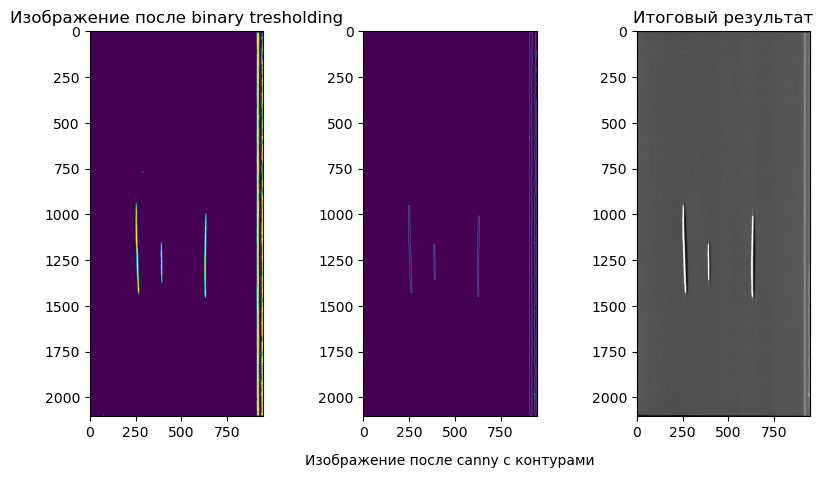

In [12]:
# Изобразим процесс:

pic_index = 11 #изменяя индекс, можно смотреть процесс для любой из 12 картинок
plot_three_images(process_images[pic_index][0], process_images[pic_index][1], the_resulting_detection[pic_index], "Изображение после binary tresholding", "Изображение после canny c контурами", "Итоговый результат")

Тепеь перейдем к остальным дефектам:

In [13]:
# Эта функция для распознавания мелких дефетов, она более чувствительная

def find_small_scratches(image, produce_mask = False, process = False):
    
    pr_store = []
    
    # Создаем копию изображения для обработки
    img = copy.deepcopy(image)
    
    # Сглаживаем изображение с помощью фильтра Гаусса для уменьшения шумов
    img_blur = cv2.GaussianBlur(img, (9,9), 0)
    img_blur = cv2.GaussianBlur(img_blur, (5,5), 0)

    # Применяем детектор краев Canny
    edges = cv2.Canny(img_blur, threshold1=10, threshold2=40)
    edges = cv2.dilate(edges, (5, 5), iterations = 3) 
    pr_store.append(copy.deepcopy(edges))

    # Находим контуры на изображении
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    imc = copy.deepcopy(image)
    cv2.drawContours(imc, contours, -1, (255, 255, 255), 10)
    pr_store.append(copy.deepcopy(imc))
    
    # Определяем площадь каждого контура
    areas = [cv2.contourArea(c) for c in contours]
    sorted_contours = [contours[i] for i in np.argsort(areas)]

    # Получаем индекс контура, соответствующий нижнему квартилю по площади
    lower_quartile_index = int(len(sorted_contours) * 0.25)

    # Отбрасываем нижний квартиль по площади, это шумы и совсем мелкие дефекты
    contours = sorted_contours[lower_quartile_index:]

    # Получаем высоту и ширину изображения
    height, width = img.shape[:2]

    # Фильтруем контуры по их положению и размеру, контуры совсем близкие к краям отбросим, так как они 
    # обычно явлюятся границами гипсокартона
    margin_threshold = 0.05 # контуры в 5% границе от краев отбрасываются
    contours_filtered = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x > margin_threshold * width and y > margin_threshold * height and x + w < (1 - margin_threshold) * width and y + h < (1 - margin_threshold) * height:
            contours_filtered.append(contour)
            
    # Если хотим получить маску то рисуем контуры на заготовке
    if produce_mask:
        mask = np.zeros_like(image)
        for contour in contours_filtered:
            hull = cv2.convexHull(contour)
            cv2.fillConvexPoly(mask, hull, 255)
        ret, binary_mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)
        return binary_mask

    # Если не хотим, то для каждого контура, удовлетворяющего условиям, строим выпуклую оболочку чтобы закрасить внутренности дефектов
    # и закрашиваем ее на изображении
    for contour in contours_filtered:
        hull = cv2.convexHull(contour)
        cv2.fillConvexPoly(img, hull, 255)
        

    # Если хотим получить процесс, возвращаем его
    if process:
        return pr_store
    # Возвращаем картинку с подсвеченными дефектами
    return img

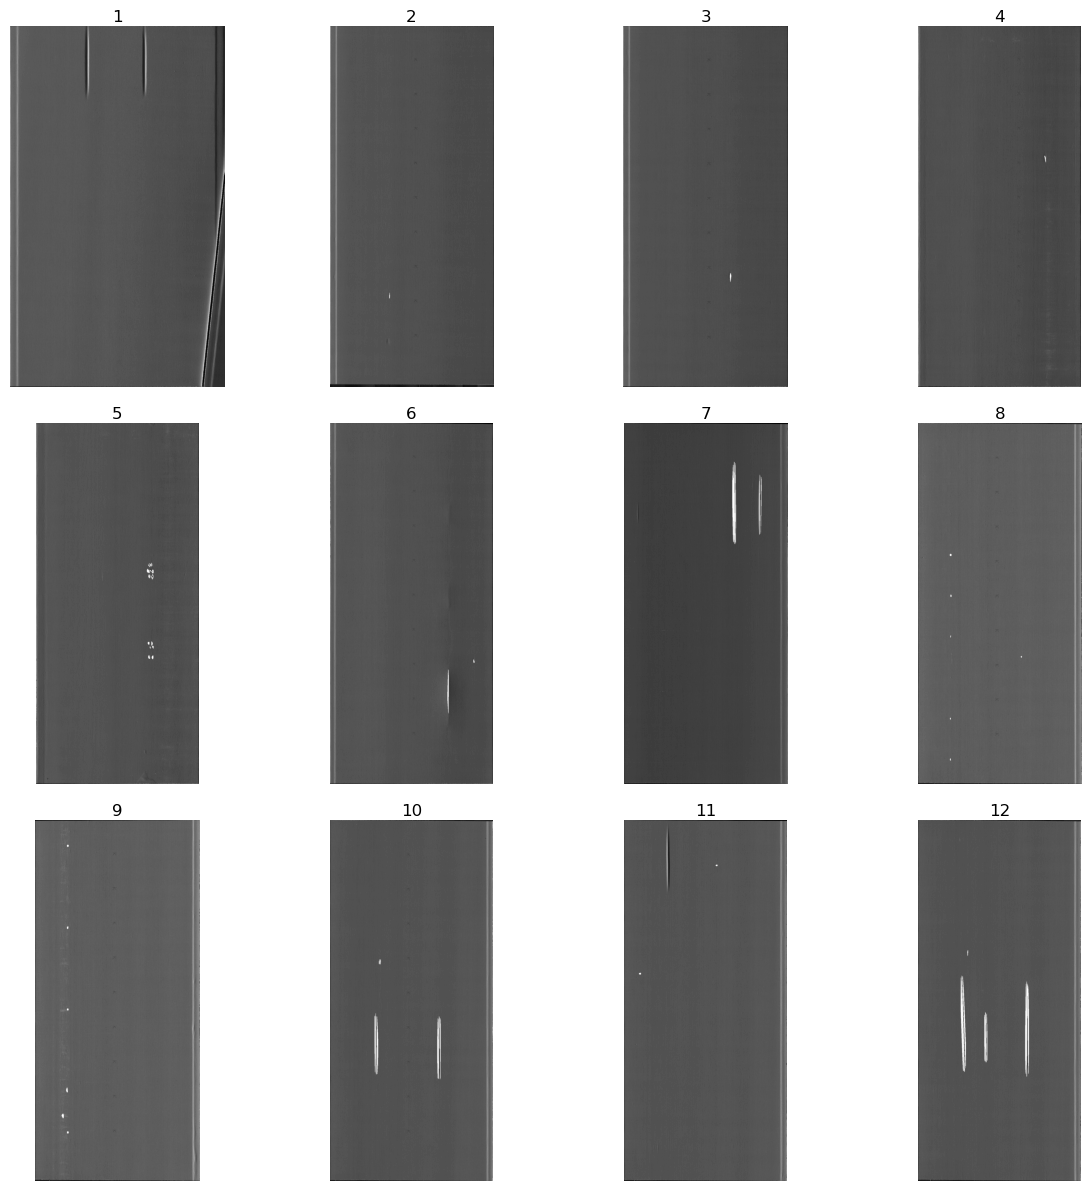

In [14]:
img_small = [find_small_scratches(copy.deepcopy(i)) for i in img_dc]
plot_12_images(img_small, figsize=(15, 15)) #Нарисуем картинки

Видим что теперь более мелкие царапины распознаны и помечены

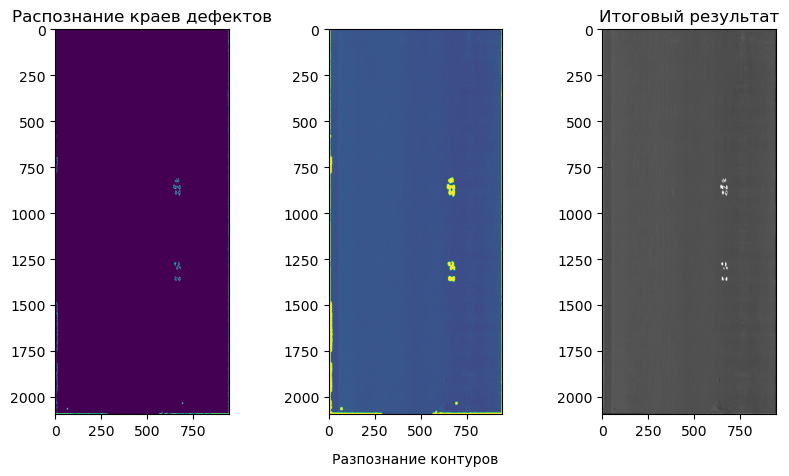

In [15]:
# Покажем процесс
process_images = [find_small_scratches(copy.deepcopy(i), process = True) for i in img_dc] #загружаем картинки из процесса


pic_index = 4 #изменяя индекс, можно смотреть процесс для любой из 12 картинок
plot_three_images(process_images[pic_index][0], process_images[pic_index][1], img_small[pic_index], "Распознание краев дефектов", "Разпознание контуров", "Итоговый результат")


Мы видим что частично мелкие дефекты отловились, однако изгибы и потертости детектировать сложнее,
Я пытался как-то применить градиенты или LOG, но не вышло, видимо нужно искать более хитрое решение

In [16]:
# Получаем маски 
masks_big_scratches = [detect_long_scratches(i, True) for i in img_dc] # Получим маски больших царапин
masks_small_objects = [find_small_scratches(i, True) for i in img_dc] # Получим маски мелких дефектов

# Объединяем маски
combine_masks = lambda masks_big_scratches, masks_small_objects: [cv2.bitwise_or(mask1, mask2) for mask1, mask2 in zip(masks_big_scratches, masks_small_objects)]
combined_masks  = combine_masks(masks_big_scratches, masks_small_objects)

In [17]:
# Функция чтобы спроецировать маски на пустые маски такого же размера как изначальные изображения
def project_masks_to_original_images(original_images, subimage_masks, transform_matrices):
    projected_masks = []
    for original_image, subimage_mask, transform_matrix in zip(original_images, subimage_masks, transform_matrices):
        # Принимаем размеры оригинального изображения
        h, w = original_image.shape[:2]

        # Создаем маску того же размера
        dummy_mask = np.zeros((h, w), dtype=np.uint8)

        # Проецируем на нее маску, предварительно увеличив ее в три раза (до этого мы уменьшали размер изображения)
        inv_transform_matrix = cv2.invert(transform_matrix)[1]
        subimage_mask = cv2.resize(subimage_mask, None, fx=3, fy=3)
        projected_mask = cv2.warpPerspective(subimage_mask, inv_transform_matrix, (w, h))

        # Добавим маску в список
        projected_masks.append(projected_mask)

    return projected_masks

In [18]:
proj_masks = project_masks_to_original_images(img_list, combined_masks, transforms)

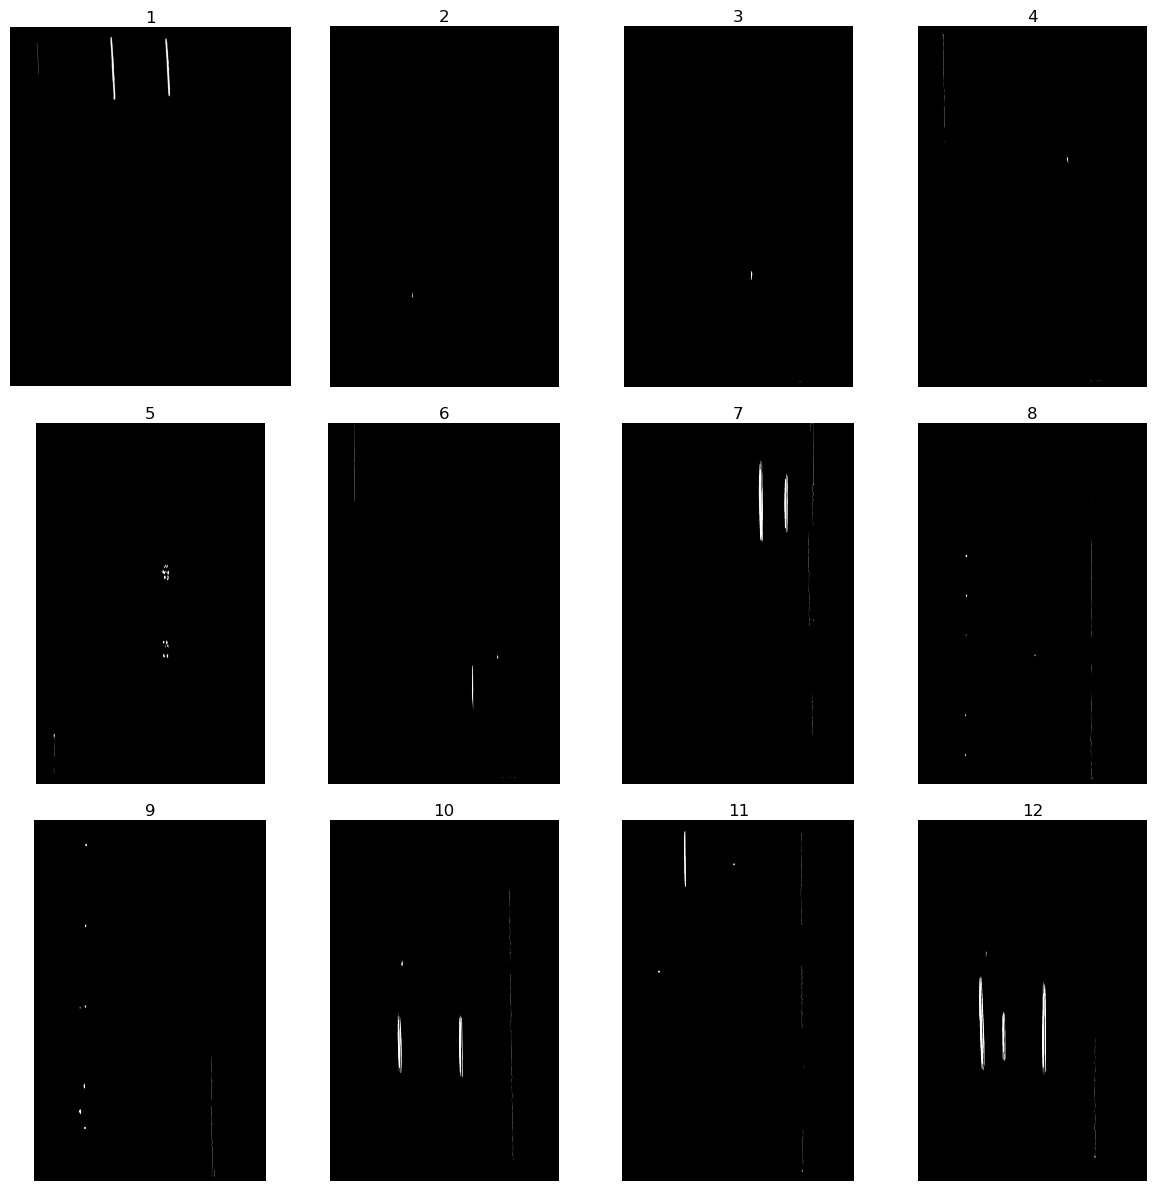

In [19]:
plot_12_images(proj_masks)

In [20]:

def calculate_iou(true_masks, pred_masks):


    iou_list = []
    for i in range(len(true_masks)):
        true_mask = true_masks[i]
        pred_mask = pred_masks[i]
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()
        iou = intersection / union if union != 0 else 0.0
        iou_list.append(int(iou*100))
    return iou_list

In [21]:
IOU = calculate_iou(mask_list, proj_masks) #IOU полученного решения; IOU лежит от нуля до 100 процентов
for i, elem in enumerate(IOU):
    print("Для изображение " + str(i+1) + " IOU равен " + str(elem))

Для изображение 1 IOU равен 39
Для изображение 2 IOU равен 10
Для изображение 3 IOU равен 32
Для изображение 4 IOU равен 0
Для изображение 5 IOU равен 21
Для изображение 6 IOU равен 5
Для изображение 7 IOU равен 57
Для изображение 8 IOU равен 0
Для изображение 9 IOU равен 0
Для изображение 10 IOU равен 52
Для изображение 11 IOU равен 26
Для изображение 12 IOU равен 68


Метрики: что касается больших царапин, они распознаны все, так что в этом плане алгоритм успешен, 
Что касается мелких царапин, сложно сказать точно, так как зачастую алгоритм находил более мелкие изъяны на
изображении, но также искал и большие дефекты, так что в целом какаую-то точность алгоритм выдает
Потертости обнаружить не получилось, возможно дело в подходе, находились отдельные точки на изображении

Усли смотреть на IOU он в целом колеблется
от нуля до 68%, что кажется плохо, однако очень многое зависит от разметки, сделать ее чуть толще, 
и хотя дефект и обнаружен, но размер UNION-a сразу увеличивается, собственно это и происходит на изображении 9
где есть жирная полоса потертости 